# Randomized Benchmarking: Interleaved RB

In this notebook we explore the subset of methods in `randomized_benchmarking.py` that are related specifically to interleaved randomized benchmarking (IRB). I suggest reviewing the [notebook](randomized_benchmarking.ipynb) `examples/randomized_benchmarking.ipynb` first, since we will assume familiarity with its contents and treat IRB as a modification to the 'standard' RB protocol.

In standard RB we are interested in characterizing the average impact of noise on our gates, and we estimate an average error rate per Clifford. Interleaved RB is designed to characterize a particular gate, which is 'interleaved' throughout the standard RB sequence. The protocol is a simple extension of standard RB which involves running sequences of random Cliffords with the gate of interest G interleaved after every Clifford. Specifically, we transform a standard RB sequence

$$C_1, C_2, C_3, \dots , C_{N-1}, C_{\textrm{inverse}}$$

into an 'interleaved' sequence

$$C_1, G, C_2, G, C_3, G, \dots , C_{N-1}, G, C'_{\textrm{inverse}}$$

where G is the gate we wish to characterize. Note that we still need to invert the sequence, so G must be an element of the Clifford group, and the final inverting gate must be updated to invert the entire sequence of gates including the G.


The IRB protocol can be summarized as follows:

- we want to characterize a gate G which acts on the set of qubits Q
- run standard RB on the qubits Q and estimate an rb decay. 
- generate another set of sequences with the gate G interleaved in each sequence. Run these sequences exactly as you would for standard RB and estimate an rb decay, which we will call the irb decay. We expect this parameter to be smaller than the standard rb decay due to the effect of the extra applications of G. 
- use the two decay parameters to calculate the error on gate G. We can also get lower and upper bounds on the fidelity of G.
- (Optional) run a unitarity experiment on the qubits Q and use this to improve the fidelity bounds from the last step.

The following is a starting point for more information

| [IRB] *Efficient measurement of quantum gate error by interleaved randomized benchmarking*.  
|     Magesan et al.  
|     Phys. Rev. Lett. 109, 080505 (2012).  
|     https://dx.doi.org/10.1103/PhysRevLett.109.080505  
|     https://arxiv.org/abs/1203.4550  

## The code
The difference between an RB experiment and an IRB experiment is one flag in `generate_rb_experiments`, so we'll go through this quickly. Refer to `examples/randomized_benchmarking.ipynb` for a more careful breakdown. 

In [1]:
# Needs in terminal:
# $ quilc -S
# $ qvm -S

import numpy as np

from pyquil.api import BenchmarkConnection, get_qc
from forest.benchmarking.randomized_benchmarking import *
from forest.benchmarking.plotting import plot_figure_for_fit

from pyquil.gates import *
from pyquil import Program


%matplotlib inline

Get a quantum computer and benchmarker object per usual

In [2]:
bm = BenchmarkConnection()
qc = get_qc("9q-square-qvm", noisy=True)

### Generate an RB and IRB experiment
We'll start be selecting our gate and hyperparameters. Then we generate two sets of experiments. The first set is the standard RB sequences and the second set has our gate interleaved in the sequences

In [3]:
# Choose your gate
qubits = (0, 1)
gate = Program(CNOT(*qubits))

# Choose your parameters
qubit_groups = [qubits]
depths = [2, 15, 25, 30, 60]
num_sequences = 25
depths = [d for d in depths for _ in range(num_sequences)]

rb_expts = generate_rb_experiments(bm, qubit_groups, depths)
# provide the extra arg for the interleaved gate
inter_expts = generate_rb_experiments(bm, qubit_groups, depths, interleaved_gate=gate)

### Run the standard RB experiment

This takes around a minute. We extract the estimated decay parameter and plot the results.

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


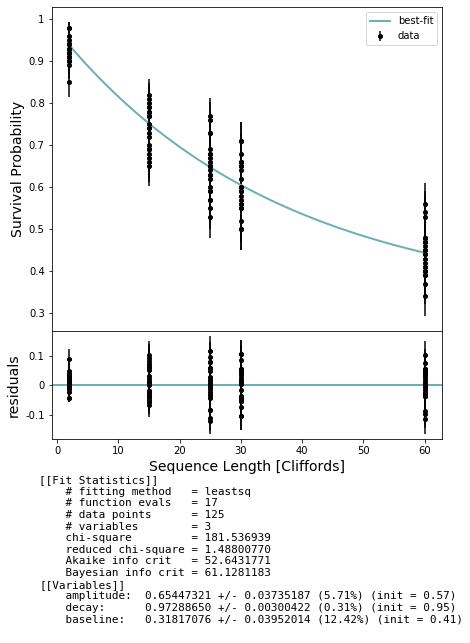

In [4]:
# NBVAL_SKIP
# tag this cell to be skipped during testing

# Run the RB Sequences on a QuantumComputer
num_shots=100
rb_results = acquire_rb_data(qc, rb_expts, num_shots, show_progress_bar=True)

# Calculate a fit to a decay curve
stats = get_stats_by_qubit_group(qubit_groups, rb_results)[qubit_groups[0]]
fit = fit_rb_results(depths, stats['expectation'], stats['std_err'], num_shots)

# Extract rb decay parameter
rb_decay = fit.params['decay'].value
rb_decay_error = fit.params['decay'].stderr

# Plot
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")

### Now run the interleaved RB experiment

This takes a bit longer than the last cell.

100%|██████████| 125/125 [01:41<00:00,  1.23it/s]


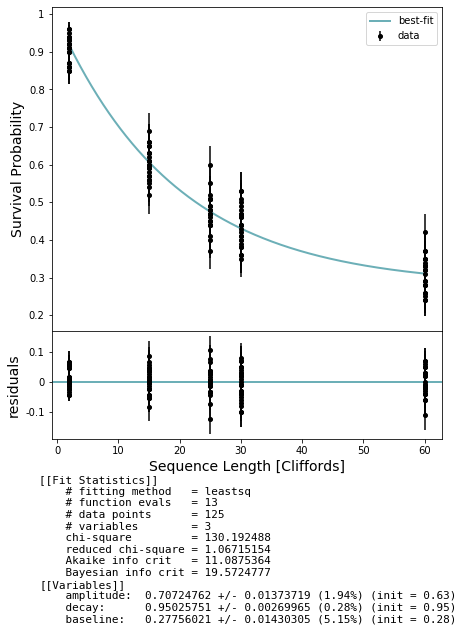

In [5]:
# NBVAL_SKIP
# tag this cell to be skipped during testing

# Run the RB Sequences on a QuantumComputer
num_shots=100
inter_results = acquire_rb_data(qc, inter_expts, num_shots, show_progress_bar=True)

# Calculate a fit to a decay curve
stats = get_stats_by_qubit_group(qubit_groups, inter_results)[qubit_groups[0]]
fit = fit_rb_results(depths, stats['expectation'], stats['std_err'], num_shots)

# Extract irb decay parameter
irb_decay = fit.params['decay'].value
irb_decay_error = fit.params['decay'].stderr

# Plot
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")

We expect the irb_decay to be somewhat smaller due to the effect of the extra instances of the interleaved gate adding noise.

In [6]:
print(rb_decay)
print(irb_decay)

0.97288649829259
0.950257506322514


### Extracting gate error and bounds

Using these two decay values we can estimate the error on our chosen gate.

In [7]:
dim = 2**len(qubits)
print(rb_decay_to_gate_error(rb_decay, dim))
gate_error = irb_decay_to_gate_error(irb_decay, rb_decay, dim)
print(gate_error)

0.020335126280557503
0.017444731741413116


We can also get bounds on our estimate using the two decay values. 

In [8]:
bounds = interleaved_gate_fidelity_bounds(irb_decay, rb_decay, dim)
print(bounds)

[0.959329747438885, 1.0057807890782888]


In [9]:
assert(bounds[0] < 1-gate_error and 1-gate_error < bounds[1])

### Improving the bounds with unitarity

To get improved bounds we can run an additional unitarity experiment, following the method described in [U+IRB].

See `examples/randomized_benchmarking_unitarity.ipynb` if unitarity RB is unfamiliar. This is particularly SLOW. 

| [U+IRB]  *Efficiently characterizing the total error in quantum circuits*.  
|     Dugas et al.  
|     arXiv:1610.05296 (2016).  
|     https://arxiv.org/abs/1610.05296  

100%|██████████| 125/125 [07:32<00:00,  3.62s/it]


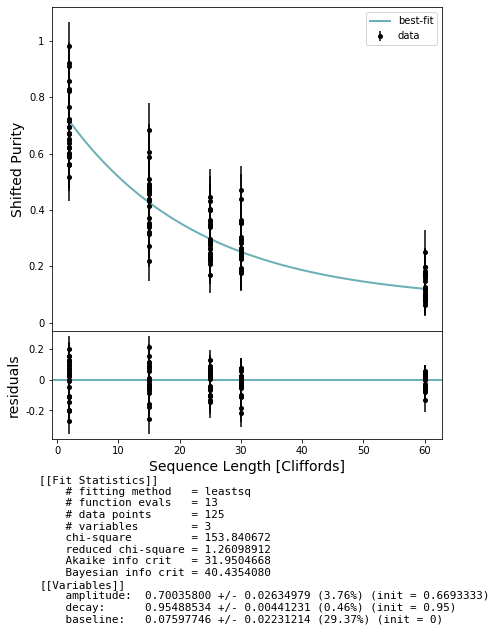

In [10]:
# NBVAL_SKIP
# tag this cell to be skipped during testing. It is particularly SLOW, around 6 minutes

num_shots = 50

expts = generate_unitarity_experiments(bm, qubit_groups, depths, num_sequences)

results = acquire_rb_data(qc, expts, num_shots, show_progress_bar=True)
stats = get_stats_by_qubit_group(qubit_groups, results)[qubit_groups[0]]
fit = fit_unitarity_results(depths, stats['expectation'], stats['std_err'])

# plot the raw data, point estimate error bars, and fit
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity")
unitarity = fit.params['decay'].value

Hopefully the `unitarity` can be incorporated to improve our bounds. However, the bounds might be `NaN` depending on the outcome of the unitarity and difference between rb and irb decays. Getting better estimates of each parameter helps prevent this.

In [11]:
better_bounds = interleaved_gate_fidelity_bounds(irb_decay, rb_decay, dim, unitarity)
print(better_bounds)

[0.9597518532587754, 0.9925052728337453]
